In [9]:
protein = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1, 0, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    protein,
    n_start=3,
    n_generate=1000,
    endo_or_exo_probability=[.5,.5],
    enzymes=enzymes,
)
print(len(sequence_graph.edges()))

 1 / 1000 (4)

 80 / 1000 (115)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:218: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 999 / 1000 (1430)
92 unique peptides. 1003 total
262


 499 / 500 | 0.11, kl: 0.11, reg: 0.00  | nz: 1071 | 

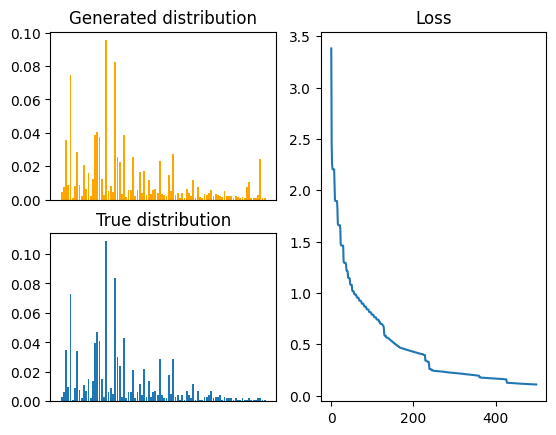

In [10]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

wegd = WeightEstimatorGD(lr=.01, n_iterations=500)
G = wegd.run(P, verbose=True)
generated = wegd.generated
losses = wegd.losses
weights = wegd.weights

fig, axs = plt.subplot_mosaic(
    [["generated", "loss"], ["true", "loss"]], width_ratios=[2, 2]
)


axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated[len(generated.keys()) -1 ].keys(),
    generated[len(generated.keys())-1].values(),
    color="orange",
)
axs["loss"].plot(losses)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["loss"].set_title("Loss")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

0.17344414134365285

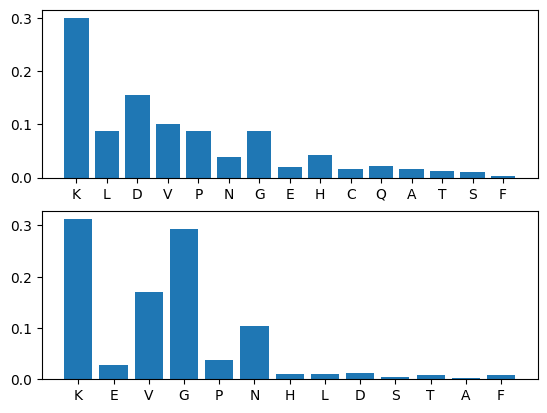

In [11]:
from disassembly.cut_site import get_p1

p1, p1_exo,  exo, endo = get_p1(G, 5000)
fig, axs = plt.subplots(2,1)
axs[0].bar(p1.keys(), height=p1.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
endo/(exo+endo)

In [12]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes_mc(sequence_graph, N_particles=10000)
get_disassembly(P, real_disassembly_indexes)


 Averaged DI: 3.23


75.55751008778498

In [13]:
from disassembly.disassembly import get_disassembly_indexes_mc

mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(P, mc_di)


 Averaged DI: 3.03


32.826809494463724

Text(0.5, 0.98, 'Disassembly indexes')

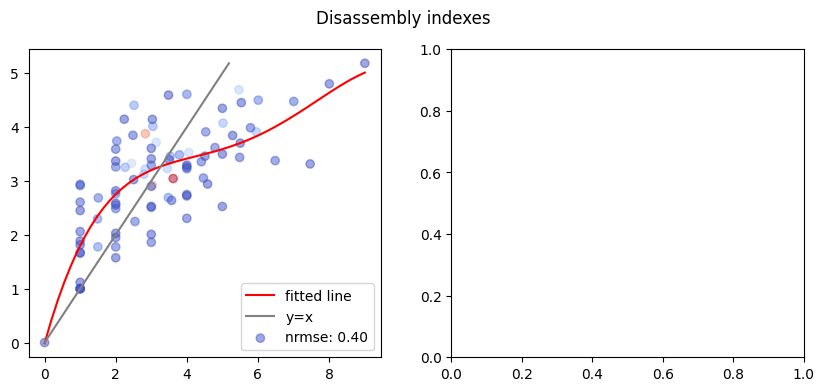

In [14]:
from scipy.stats import linregress
import numpy as np

# fig, axs = plt.subplots(1,3, figsize=(12,4))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
trues = []
ys_e = []
ys_mc = []
c = []


def get_nrmse(true, observed):
    true = np.array(true)
    observed = np.array(observed)
    rmse = np.sqrt(np.mean((true - observed)**2))
    nrmse = rmse / np.mean(true)
    return nrmse           


for key in P.keys():
    if str(np.mean(mc_di[key])) == "nan":
        print(key)
        continue
    trues.append((real_disassembly_indexes[key]))
    # ys_e.append((estimated_disassembly_indexes[key]))
    ys_mc.append(mc_di[key])
    c.append(P[key])
a = 0
# for xs, ys in [(trues, ys_e), (trues, ys_mc), (ys_e, ys_mc)]:
for xs, ys in [(trues, ys_mc)]:
    regress = np.polyfit(xs, ys, 4)
    nrmse = get_nrmse(xs, ys)
    axs[a].plot(
        np.linspace(0, max(xs)),
        regress[0] * np.linspace(0, max(xs))**4 +
         regress[1] * np.linspace(0, max(xs))**3 +
          regress[2] * np.linspace(0, max(xs))**2 +
           regress[3] * np.linspace(0, max(xs)) +
            regress[4],
        label="fitted line",
        color="red"
    )
    axs[a].plot(
        np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x"
    )
    axs[a].scatter(
        xs, ys, label=f"nrmse: {nrmse:.2f}", c=c, cmap="coolwarm", alpha=0.5
    )
    axs[a].legend()
    a += 1

plt.suptitle("Disassembly indexes")

In [15]:
import networkx as nx
import pandas as pd

aG = pd.DataFrame(
    nx.adjacency_matrix(G, nodelist=G.nodes()).toarray().T,
    index=G.nodes(),
    columns=G.nodes(),
).sort_index(key=lambda x: x.str.len())
aG = aG[aG.index]
pG = pd.DataFrame(
    nx.adjacency_matrix(sequence_graph, nodelist=G.nodes()).toarray().T,
    index=sequence_graph.nodes(),
    columns=sequence_graph.nodes(),
).sort_index(key=lambda x: x.str.len())
pG = pG[pG.index]

170 47.59069816056421 191.7119068113524


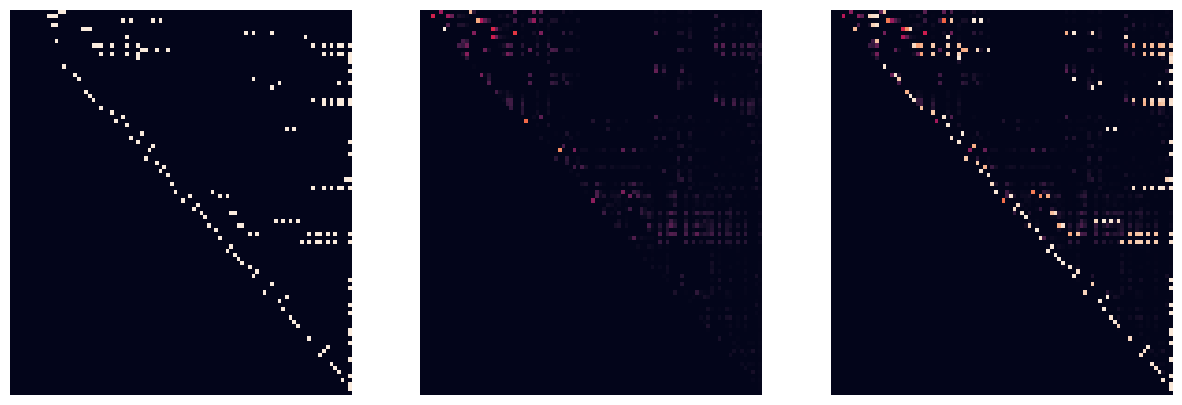

In [16]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(pG, ax=axs[0], cbar=None)
sns.heatmap(aG, ax=axs[1], cbar=None)
sns.heatmap(np.abs(pG - aG), ax=axs[2], cbar=None)

print(sum(sum(pG.values)), sum(sum(aG.values)), sum(sum(np.abs(pG - aG).values)))

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])